In [26]:
import csv
import time as tm
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from collections import deque

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization

import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv('GOTO.csv', delimiter=',')

In [28]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-17,218.0,218.0,210.0,214.0,214.0,516263700
1,2022-11-18,216.0,226.0,212.0,222.0,222.0,1401184800
2,2022-11-21,220.0,220.0,210.0,210.0,210.0,970473000
3,2022-11-22,210.0,210.0,196.0,196.0,196.0,1594524700
4,2022-11-23,192.0,198.0,190.0,191.0,191.0,876202200


In [35]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [36]:
df

,Date,Close
0,2022-11-17,214.0
1,2022-11-18,222.0
2,2022-11-21,210.0
3,2022-11-22,196.0
4,2022-11-23,191.0
...,...,...
238,2023-11-13,79.0
239,2023-11-14,81.0
240,2023-11-15,86.0
241,2023-11-16,86.0


In [40]:
N_STEPS = 7

LOOKUP_STEPS = [1, 2, 3]


# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

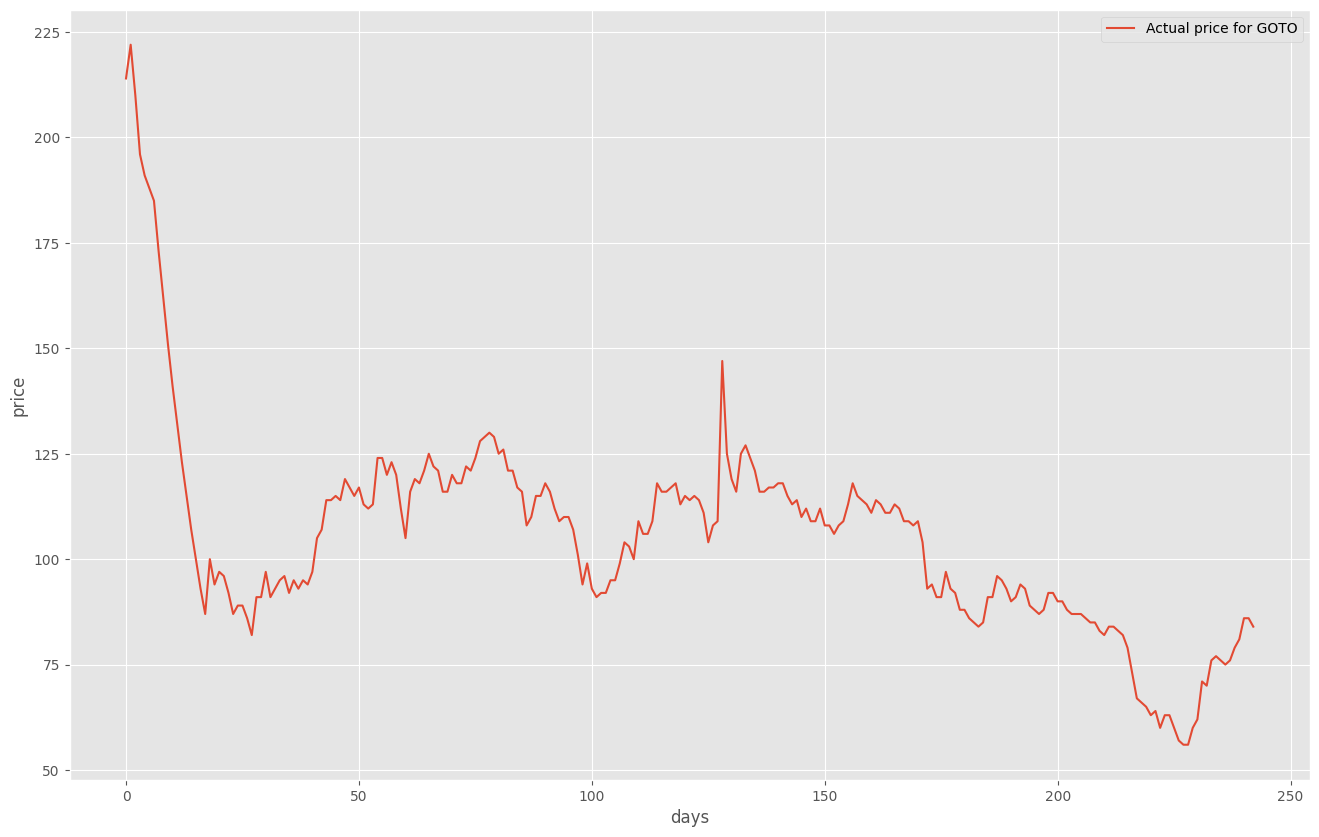

In [37]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(df['Close'], label='Close Price history')
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for GOTO'])
plt.show()

In [38]:
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(np.expand_dims(df['Close'].values, axis=1))

In [39]:
df

,Date,Close
0,2022-11-17,0.951807
1,2022-11-18,1.000000
2,2022-11-21,0.927711
3,2022-11-22,0.843373
4,2022-11-23,0.813253
...,...,...
238,2023-11-13,0.138554
239,2023-11-14,0.150602
240,2023-11-15,0.180723
241,2023-11-16,0.180723


In [45]:
def PrepareData(days):
  df['Future'] = df['Close'].shift(-days)
  last_sequence = np.array(df[['Close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['Close'] + ['Date']].values, df['Future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['Close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [46]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [47]:
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['Close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
30/30 [==============================] - 20s 13ms/step - loss: 0.0136
Epoch 2/80
30/30 [==============================] - 0s 12ms/step - loss: 0.0038
Epoch 3/80
30/30 [==============================] - 0s 12ms/step - loss: 0.0033
Epoch 4/80
30/30 [==============================] - 0s 12ms/step - loss: 0.0037
Epoch 5/80
30/30 [==============================] - 0s 12ms/step - loss: 0.0033
Epoch 6/80
30/30 [==============================] - 0s 12ms/step - loss: 0.0034
Epoch 7/80
30/30 [==============================] - 0s 12ms/step - loss: 0.0028
Epoch 8/80
30/30 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 9/80
30/30 [==============================] - 0s 12ms/step - loss: 0.0032
Epoch 10/80
30/30 [==============================] - 0s 12ms/step - loss: 0.0029
Epoch 11/80
30/30 [==============================] - 0s 12ms/step - loss: 0.0026
Epoch 12/80
30/30 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 13/80
30/30 [=================

In [78]:
if bool(predictions) == True and len(predictions) > 0 :
    predictions_list = [str(d)+'Rp' for d in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'GOTO price in {LOOKUP_STEPS} days will be {predictions_str}'
print(message)

GOTO price in [1, 2, 3] days will be 86.64Rp, 90.69Rp, 82.7Rp


In [64]:
y_train[-3:]

array([0.12048193, 0.13855422, 0.15060241])

8/8 [==============================] - 0s 4ms/step


TypeError: float() argument must be a string or a number, not 'datetime.date'

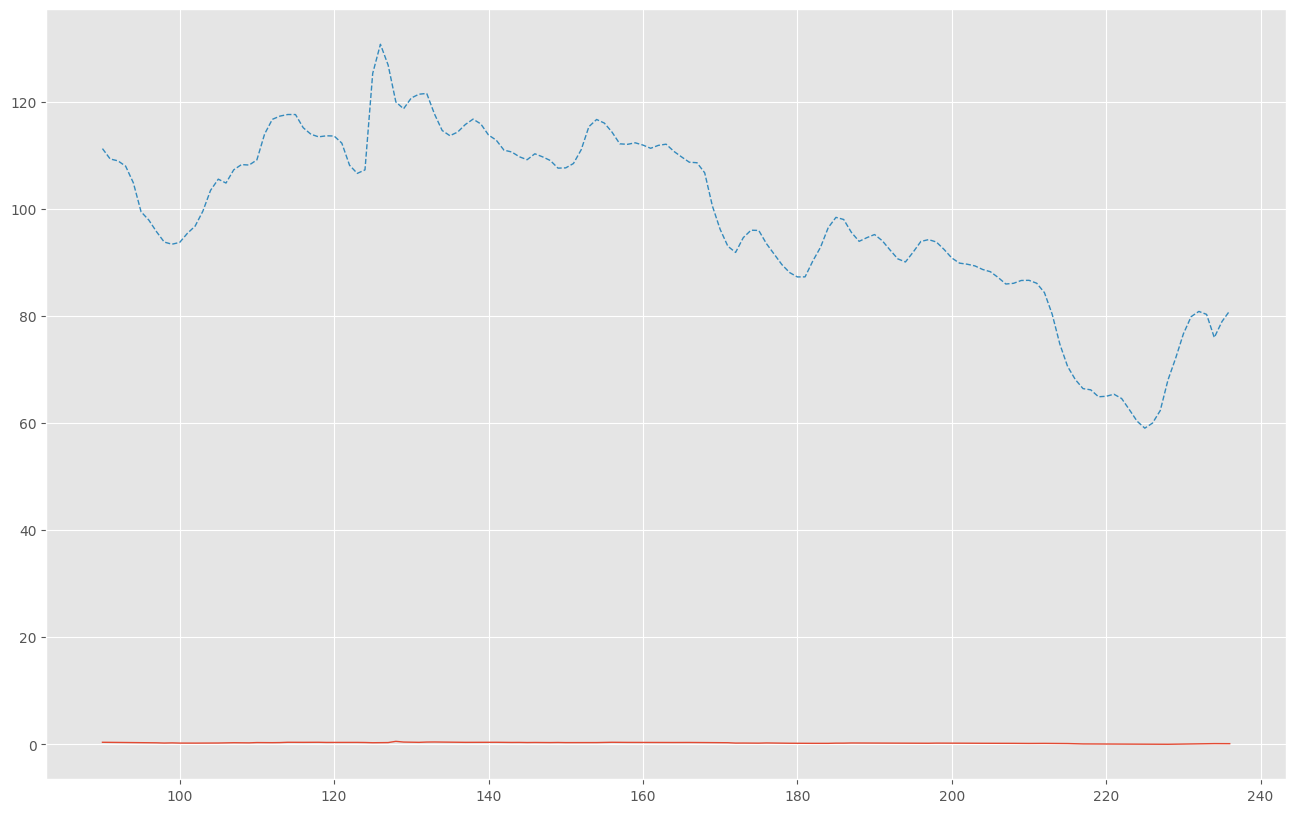

In [80]:
copy_df = df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:3], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['Close'][-150:].head(147),linewidth=1)
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['Close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for GOTO', 
            f'Predicted price for GOTO',
            f'Predicted price for future 3 days'])
plt.show()

In [58]:
model.save('stock_predict.h5')